In [7]:
import pandas as pd
from src.data import *
from src.portfolio import *
from src.efficient_frontier import *
import yfinance as yf
from datetime import datetime as dt
from scipy.optimize import Bounds, LinearConstraint

In [25]:
df = pd.read_csv('df_new.csv')

# select columns ending with '_weighted'
weighted_cols = df.columns[df.columns.str.endswith('_weighted')]

# create a new DataFrame with only the weighted columns
df_esg = df[weighted_cols]

# create a new DataFrame with the remaining columns
df_price = (df.drop(weighted_cols, axis=1).set_index('Date'))
df_price.index = pd.to_datetime(df_price.index)
df_price = currency_rates(df_price)

esg = df_esg
prices = df_price.iloc[:,:10]

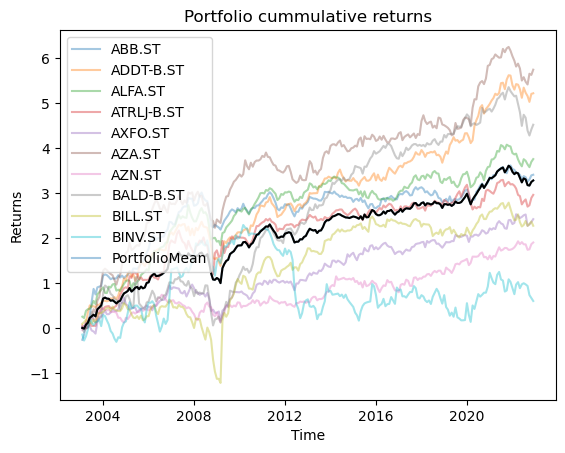

In [26]:
plot_cummulative_portfolio_returns(prices)

In [ ]:
#esg_data = pd.read_excel('ESG_DATA1.xlsx')

#for index, row in esg_data.iterrows():
#    if row['CurrencyCode'] == 'SEK':
#        esg_data.at[index, 'stock_symbol'] += '.ST'
#    elif row['CurrencyCode'] == 'NOK':
#        esg_data.at[index, 'stock_symbol'] += '.OL'
#    elif row['CurrencyCode'] == 'DKK':
#        esg_data.at[index, 'stock_symbol'] += '.CO'

In [ ]:
# extract unique stock symbols
#symbols = esg_data['stock_symbol'].unique()

# create a new dataframe to store the monthly closing data
#monthly_close = pd.DataFrame()

# create a new dataframe to store the monthly closing data
#monthly_close_esg = pd.DataFrame()

# create a new dataframe to store the monthly closing data
#monthly_close_total = pd.DataFrame()

# loop over each stock symbol and retrieve monthly data using yfinance
#for symbol in symbols:
    # retrieve data from yfinance
#    stock_data = yf.download(symbol, start='2013-01-01', end='2023-01-01', interval='1mo', progress=False)
    
    # extract the 'Close' column and rename it with the stock symbol
#    stock_data = stock_data[['Adj Close']].rename(columns={'Adj Close': symbol})
#    monthly_close = pd.concat([monthly_close, stock_data], axis=1)

    # add the weighted score for the stock
#    total_score = esg_data.loc[esg_data['stock_symbol']==symbol, 'total'].iloc[0]
#    monthly_close_esg.index = monthly_close.index
#    monthly_close_esg[symbol + '_ESG_total'] = total_score
    
#    stock_data[symbol + '_ESG_total'] = total_score
    
    # append the stock data to the monthly_close_df
#    monthly_close_total = pd.concat([monthly_close_total, stock_data], axis=1)

# print the result
#print(monthly_close_df)



In [27]:
# set the window size
window_size = 10

# make different lists to append data in every window
expected_return = []
expected_year = []

# setup af loop to iterate through window and make calculations
for i in range(0, 11):

  # define the rolling window
  rolling_window = prices[i*12:i*12+(12*window_size)]

  # calculate the expected return as a dataframe
  window_annual_return = annual_return(rolling_window.iloc[0], rolling_window.iloc[-1], window_size)

  # append the results of expected return and the years to list
  expected_return.append(window_annual_return)

# make list of expected return into a dataframe
for x in range(2013, 2024):
  expected_year.append(dt(x,1,1))
  
expected_return = pd.DataFrame(expected_return, index=expected_year)

expected_return

,ABB.ST,ADDT-B.ST,ALFA.ST,ATRLJ-B.ST,AXFO.ST,AZA.ST,AZN.ST,BALD-B.ST,BILL.ST,BINV.ST
2013-01-01,0.256886,0.259093,0.293425,0.206818,0.116719,0.298722,0.090255,0.144104,0.096199,0.031965
2014-01-01,0.183566,0.257852,0.224223,0.171920,0.117938,0.223894,0.081060,0.143020,0.094425,0.028674
2015-01-01,0.171149,0.201432,0.190633,0.142926,0.123216,0.199849,0.110758,0.190551,0.099161,0.026326
2016-01-01,0.104266,0.186435,0.161324,0.132585,0.136194,0.159009,0.092963,0.310140,0.132388,0.026494
2017-01-01,0.080247,0.129177,0.090499,0.079658,0.101725,0.127308,0.069366,0.246647,0.105321,0.015407
2018-01-01,0.075732,0.168845,0.106641,0.104102,0.116360,0.128642,0.102360,0.319032,0.155201,0.009096
2019-01-01,0.090175,0.209220,0.142076,0.118857,0.156525,0.186991,0.109519,0.418988,0.264203,0.010822
2020-01-01,0.083866,0.221013,0.105853,0.133209,0.145580,0.115309,0.117615,0.371582,0.116374,0.004269
2021-01-01,0.080928,0.214115,0.086618,0.099406,0.136130,0.169276,0.119144,0.287023,0.124418,0.006314
2022-01-01,0.110655,0.298479,0.115880,0.111979,0.154334,0.234066,0.132757,0.328113,0.139940,0.009419


In [ ]:
def ef1(ret_port, cov_port):
    bounds = Bounds(-2, 5)

    #Create x0, the first guess at the values of each asset's weight.
    w0 = np.linspace(start=1, stop=0, num=cov_port.shape[1])
    x0 = w0/np.sum(w0)
    # All weights between 0 and 1
    # The second boundary is the sum of weights.
    linear_constraint = LinearConstraint(np.ones((cov_port.shape[1],), dtype=int),1,1)
    options = {'xtol': 1e-07, 'gtol': 1e-07, 'barrier_tol': 1e-07, 'maxiter': 1000}
 
    #These are the weights of the assets in the portfolio with the lowest level of risk possible.
    w_minr = min_risk(cov_port, x0, linear_constraint, bounds)
    opt_risk_ret = portfolio_return(ret_port,w_minr)
    opt_risk_vol = portfolio_std(cov_port, w_minr)
    print(f'Min. Risk = {opt_risk_vol*100:.3f}% => Return: {(opt_risk_ret*100):.3f}%  Sharpe Ratio = {opt_risk_ret/opt_risk_vol:.2f}')

    #These are the weights of the assets in the portfolio with the highest Sharpe ratio.
    w_sr_top = max_sr(ret_port,cov_port, x0, linear_constraint, bounds, options)
    opt_sr_ret = portfolio_return(ret_port, w_sr_top)
    opt_sr_vol = portfolio_std(cov_port, w_sr_top)
    print(f'Max. Sharpe Ratio = {opt_sr_ret/opt_sr_vol:.2f} => Return: {(opt_sr_ret*100):.2f}%  Risk: {opt_sr_vol*100:.3f}%')

    frontier_y = np.linspace(-0.3, opt_sr_ret*3, 50)
    frontier_x = []

    x0 = w_sr_top
    for possible_return in frontier_y:
        cons = ({'type':'eq', 'fun': check_sum},
                {'type':'eq', 'fun': lambda w: portfolio_return(ret_port, w) - possible_return})

        #Define a function to calculate volatility
        fun = lambda w: np.sqrt(np.dot(w,np.dot(w,cov_port)))
        result = minimize(fun,x0,method='SLSQP', bounds=bounds, constraints=cons, callback=callbackF)
        frontier_x.append(result['fun'])

    frontier_x = np.array(frontier_x)
    dt_plot = pd.DataFrame(sr_opt_set, columns=['vol', 'ret'])
    vol_opt = dt_plot['vol'].values
    ret_opt = dt_plot['ret'].values
    sharpe_opt = ret_opt/vol_opt

    return opt_sr_vol, opt_sr_ret, opt_risk_vol,  opt_risk_ret, frontier_x, frontier_y, w_sr_top

In [ ]:
calculate_efficient_frontier_esg()

In [ ]:
parameters = []
for i in range(0, 11):
  sr_opt_set = set()
  print(f"-------------------------- 20{3+i:02d}-20{13+i:02d} --------------------------")


  # define the rolling window
  sample_rolling_window = price[i*12:i*12+(12*window_size)]

  ret_port = historical_return(sample_rolling_window, frequency=12)
  print(ret_port)

  ret_port2 = annual_return(sample_rolling_window[0], sample_rolling_window[-1], window_size)
  print(ret_port2)

In [ ]:
#mpl.style.use('classic')
mpl.style.use('default')

fig, ax = plt.subplots()
plt.title('Efficient Frontier for rolling windows', fontsize=12)
plt.xlabel('Risk/Volatility')
plt.ylabel('Return')
colors = ['r','b','k','m','g','c', 'lightslategrey', "darkcyan", "purple", "orange", "olive"]
for i, x in enumerate(parameters):
  opt_sr_vol, opt_sr_ret, opt_risk_vol,  opt_risk_ret, frontier_x, frontier_y, _ = x
  #ax.plot(opt_sr_vol, opt_sr_ret,'*', markersize=20, label=f'20{3+i:02d}-20{13+i:02d} Max Sharpe') # red star
  plt.plot(opt_sr_vol,  opt_sr_ret, marker='o', color = f'{colors[i]}', markersize=12)# label=f'20{3+i:02d}-20{13+i:02d} Min var') # red dot
  plt.plot(frontier_x, frontier_y, linestyle='--', color = f'{colors[i]}', linewidth=3, label=f'20{3+i:02d}-20{13+i:02d} Efficient Frontier') # red dashed line
  
  #ax.scatter(x[2], x[1], marker="*", s=100, label=f"20{3+i:02d}-20{13+i:02d} Max Sharpe")
plt.xlim([0,1])
plt.ylim([frontier_y.min(),frontier_y.max()])
plt.legend(bbox_to_anchor =(0.5, 0.9, 1, 0), ncol = 1, fontsize="small")
#fig_path = os.path.join(PLOTS_PATH, f"efficient_frontier.png")
#plt.savefig(fig_path, dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
portfolio_covariance(df)

In [ ]:
portfolio_mean(df)

In [ ]:
cov = portfolio_covariance(df)
portfolio_std(cov, w)

In [ ]:
portfolio_sharp_ratio(df, w, cov)

In [ ]:
#bounds = Bounds(-2, 5)

#Create x0, the first guess at the values of each asset's weight.
#w0 = np.linspace(start=1, stop=0, num=cov.shape[1])
#x0 = w0/np.sum(w0)
# All weights between 0 and 1
# # The second boundary is the sum of weights.
#linear_constraint = LinearConstraint(np.ones((cov.shape[1],), dtype=int),1,1)
#options = {'xtol': 1e-07, 'gtol': 1e-07, 'barrier_tol': 1e-07, 'maxiter': 1000}
 

In [ ]:
def portfolio_minimize_risk(port_return, 
                                port_covariance, 
                                esg_data, 
                                x0,
                                linear_constraint, 
                                bounds, 
                                options = None):
    """
    Function that will take different inputs including esg score data and compute the minimum risk of different portfolios 
    :param: A dataframe of the portfolio covariance matrix
    :param: A dataframe of esg scores of the different assets in portfolio
    :param: x0 argument that is the initial guess for the minimizer
    :param: Linear constraints for the minimizer
    :param: Bounds for the minimizer
    :param: 
    :param: Options for the minimizer
    :returns: A dataframe containing portfolio weight choice for minimizing portfolio risk using esg scores
    """
    
    results = {'esg':[],
               'weights':[],
               'risk':[],
               'return':[]}
    
    function = lambda weight: portfolio_std(port_cov=port_covariance, weights=weight)
    constraint_esg = {'type': 'eq', 'fun': lambda weight: np.dot(weight, esg_data)}
    result = minimize(function, 
                      x0, 
                      method='trust-constr', 
                      bounds=bounds, 
                      constraints=[linear_constraint, constraint_esg], 
                      options=options)
   
    optimal_weights = list(result['x'])
    print(optimal_weights)
    optimal_esg = np.dot(optimal_weights, esg_data)
    results['esg'].append(optimal_esg)
    results['weights'].append(optimal_weights)
    results['risk'].append(result['fun'])
    results['return'].append(np.dot(optimal_weights, port_return.sum()))

    return results


In [ ]:
# set the window size
#window_size = 2

# make different lists to append data in every window
#expected_return = []
#expected_year = []

#def simple_return(beginning_price, end_price):
#  return ((end_price-beginning_price)/beginning_price)

#def annual_return(simple_return, years_held):
#  return (((simple_return+1)**(1/years_held))-1)

# setup af loop to iterate through window and make calculations
#for i in range(0, 6):

  # define the rolling window
#  sample_rolling_window = df[i*12:i*12+(12*window_size)]

  # calculate the expected return as a dataframe
#  window_monthly_returns = pd.DataFrame()
#  window_monthly_returns = sample_rolling_window
#  simple_window_yearly_returns_mean = simple_return(window_monthly_returns.iloc[0], window_monthly_returns.iloc[-1])
#  annual_window_return = annual_return(simple_window_yearly_returns_mean, window_size)

  # append the results of expected return and the years to list
#  expected_return.append(annual_window_return)

# make list of expected return into a dataframe
#for x in range(2013, 2024):
#  expected_year.append(dt(x,1,1))
  
#expected_return = pd.DataFrame(expected_return, index=expected_year)

#expected_return


In [ ]:
#esg_data = pd.read_excel('ESG_DATA.XLS')
#for index, row in esg_data.iterrows():
    # stockholm exchange
    if row['Isin'].startswith('SE'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    
    # swiss exchange
    elif row['Isin'].startswith('CH0242214887'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('CH1122548808'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('CH'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SW'
    
    # toroto exchange
    elif row['Isin'].startswith('CA98936C1068'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.L'
    elif row['Isin'].startswith('CA'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.TO'
    elif row['Isin'].startswith('GB'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.L'
    
    # paris exchange
    elif row['Isin'].startswith('FR'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.PA'

    # copenhagen exchange
    
    elif row['Isin'].startswith('DK0060668796'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('DK0060520450'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('FI4000297767'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.CO' 
    elif row['Isin'].startswith('DK'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.CO'

    # oslo exchange
    elif row['Isin'].startswith('NO'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('KYG'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL' 
    elif row['Isin'].startswith('CY'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('BMG'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('MHY'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SG'
    elif row['Isin'].startswith('US36467X2062'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('SGX'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('FO0000000179'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'

    elif row['Isin'].startswith('MT0000580101'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.DE'
    elif row['Isin'].startswith('MT0001390104'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('MT'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SG'
   